# 🤒 Epidemic mitigation project - solution notebook

In [40]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gym                    import spaces

from matplotlib.patches     import Patch
from matplotlib.figure      import Figure
from matplotlib.axes        import Axes

from typing                 import List, Dict, Any

"""Environment imports"""
from epidemic_env.env import Env
from epidemic_env.dynamics import ModelDynamics # why is this needed?
from epidemic_env.visualize import Visualize


"""Deep learnining module imports"""
from deep_q_learning.agent import Agent
from deep_q_learning.trainer import AbstractTrainer


"""Should be written by the student"""
# from deep_q_learning.agent import DQNAgent, FactoredDQNAgent, NaiveAgent
# from deep_q_learning.trainer import Trainer
# import deep_q_learning.model as models

'Should be written by the student'

## 1. Introduction

### Question 1.a) study the behavior of the model when the epidemics are unmitigated

First we define the plotting function :

In [24]:
%matplotlib inline
def plot_episode(total, cities, actions=None):
    fig = plt.figure(figsize=(14,10))
    if actions:
        ax_left = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=7)
        ax_bleft = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    else:
        ax_left = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=9)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1,sharex=ax_right[0]) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_left.plot(y) for y in total.values()]
    ax_left.legend(total.keys())
    ax_left.set_title('Full state')
    
    if actions:
        ax_bleft.matshow(np.array([v for v in actions.values()]).astype(np.uint8))
        ax_bleft.set_yticklabels(['']+list(actions.keys()))
        ax_bleft.set_xlabel('weeks')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_title(c) for c, ax in ax_right.items()]
    [ax.legend(['infected','dead']) for ax in ax_right.values()]

    plt.tight_layout()
    plt.show()


Then we play through a full epidemic episode as follows:

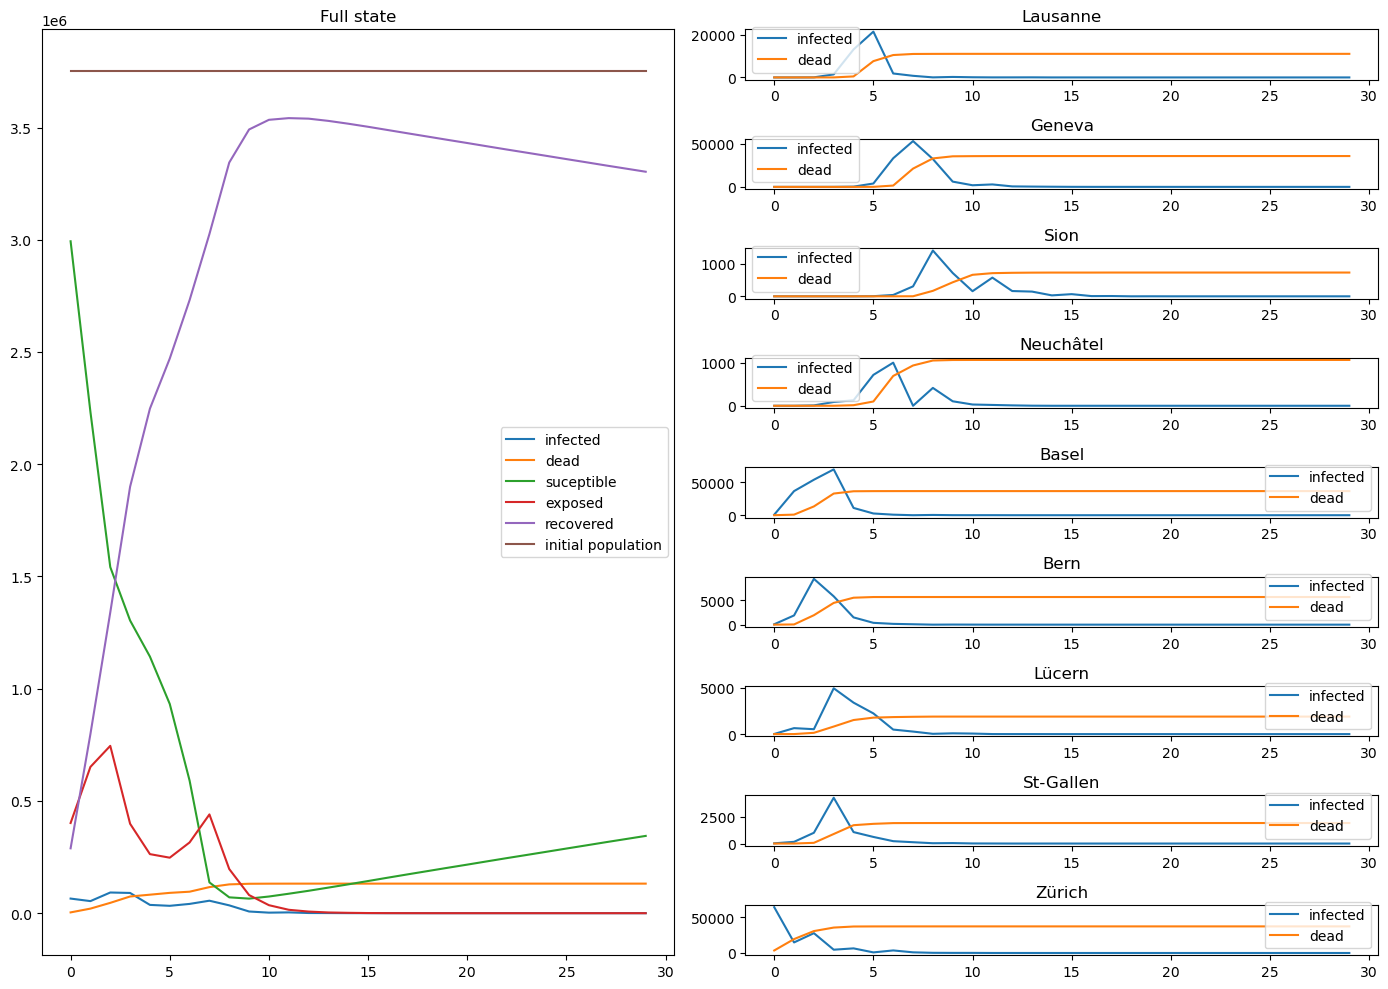

In [25]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment"""
env = Env(dyn)

action = action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

""" Run the simulation """
log = []
finished = False
obs, info = env.reset()
while not finished:
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([l['parameters']['total'][p] for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([l['parameters']['cities'][c][p] for l in log]) for p in dyn.parameters} for c in dyn.cities}
plot_episode(total, cities)

## 2. Professor Russo's Policy

### Question 2.a) implement Pr. Russo's Policy

In [26]:
class Russo(Agent):
    def __init__(self,  env:Env,
                 threshold:int=20000,
                 confine_time:int=4,):
        """Naive Agent implementation. Gives a baseline to compare reinforcement learning agents against. 
        The naive policy is the following:
        ```pseudocode
        If number of infected people > THRESHOLD
            confine the entire country for CONFINEMENT_TIME weeks
        ```

        Args:
            env (_type_): the simulation environment.
            threshold (int, optional): The infected threshold, upon which confiment must start. Defaults to 20000.
            confine_time (int, optional): The confinement time. Defaults to 4.
        """

        self.env = env
        self.threshold = threshold
        self.confine_time = confine_time
        self.timer = 0
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
        #This is agent is born stupid and stays stupid
        return 0
    
    def reset(self,):
        self.timer = 0

    def act(self, obs):
        if self.timer > 0:
            self.timer -=1
            return 1, 0
        if obs > self.threshold:
            self.timer = self.confine_time
            return 1, 0
        return 0,0

In [27]:
def russo_act_pre(a, dyn:ModelDynamics):
    return {
        'confinement': a[0]==1,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }

def russo_obs_pre(obs_dict:Dict[str,Any], dyn:ModelDynamics):
    return obs_dict['total']['infected'][-1]

In [41]:
def plot_time_boolean(dataframe: pd.DataFrame, ax: Axes, true_label:str, false_label:str):
    """Plots a vizualization of an action history (a N_CITIESxN_WEEKS boolean array) in a given matplotlib axis.

    Args:
        dataframe (pd.DataFrame): Dataframe containing the data
        ax (Axes): matplotlib axis to plot to
        true_label (str): label given to the true values
        false_label (str): label given to the false values
    """
    b_array = np.array(dataframe).transpose()*(1.0)
    ax.imshow(b_array, aspect='auto', interpolation=None,
              cmap='bwr', vmin=0, vmax=1)

    legend_elements = [Patch(facecolor='blue', label=false_label),
                       Patch(facecolor='red', label=true_label), ]

    ax.legend(handles=legend_elements)

    y_label_list = dataframe.columns
    ax.set_yticks(list(range(b_array.shape[0])), y_label_list)

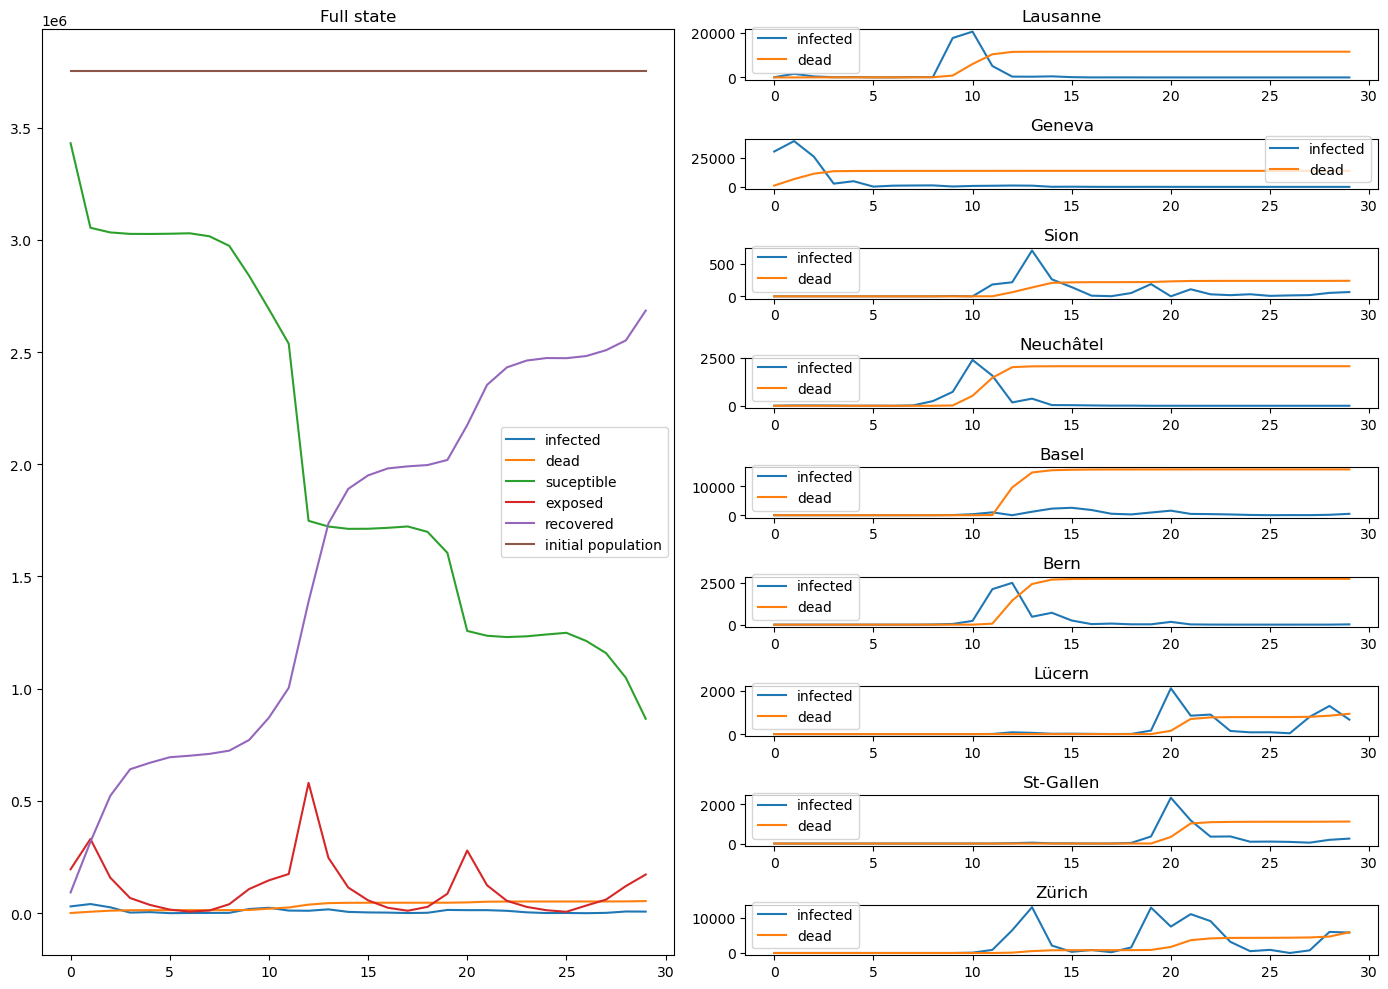

In [28]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_preprocessor=russo_act_pre,
            observation_preprocessor=russo_obs_pre)
agent = Russo(env) # defined above

""" Run the simulation """
log = []
finished = False
obs, info = env.reset()
agent.reset()
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([l['parameters']['total'][p] for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([l['parameters']['cities'][c][p] for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l['action'][a] for l in log]) for a in log[0]['action'].keys()}
(total,cities,actions)

### Question 2.b) evaluate Pr. Russo's Policy

In [ ]:
def evaluate(env, agent, eval_iterations = 50):
        results = []
        for eval_iter in range(eval_iterations):
            finished = False
            log = []; R_cum = 0;
            obs, info = env.reset()
            while not finished:
                action, est_Q = agent.act(obs)
                obs, R, finished, info = env.step(action)
                log.append(info); R_cum += R
                if finished:
                    break
            results.append({
                'log': log, 
                'R_cum': R_cum, 
            })

        return results